In [1]:
import numpy as np
import xarray as xr
from scipy import signal
from scipy import stats
import matplotlib.pyplot as plt

nino_txt= 'Niño 3.4 Index'
npp_txt = 'NWPPI'

nino = xr.open_dataarray('../../Data/originals/results/handmade_nino34.nc').squeeze()
npp = xr.open_dataarray(f'../../Data/1degree/d_l_nppa.nc').squeeze().interpolate_na(dim='date')

/var/folders/gv/5yc5yy8j1rg2ls36dbbfntr80000gn/T/ipykernel_1951/282041090.py:16: RuntimeWarning: invalid value encountered in divide
  tau = phase_xy / (2 * np.pi * f)
/var/folders/gv/5yc5yy8j1rg2ls36dbbfntr80000gn/T/ipykernel_1951/282041090.py:42: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  a.set_xlim((0,10))


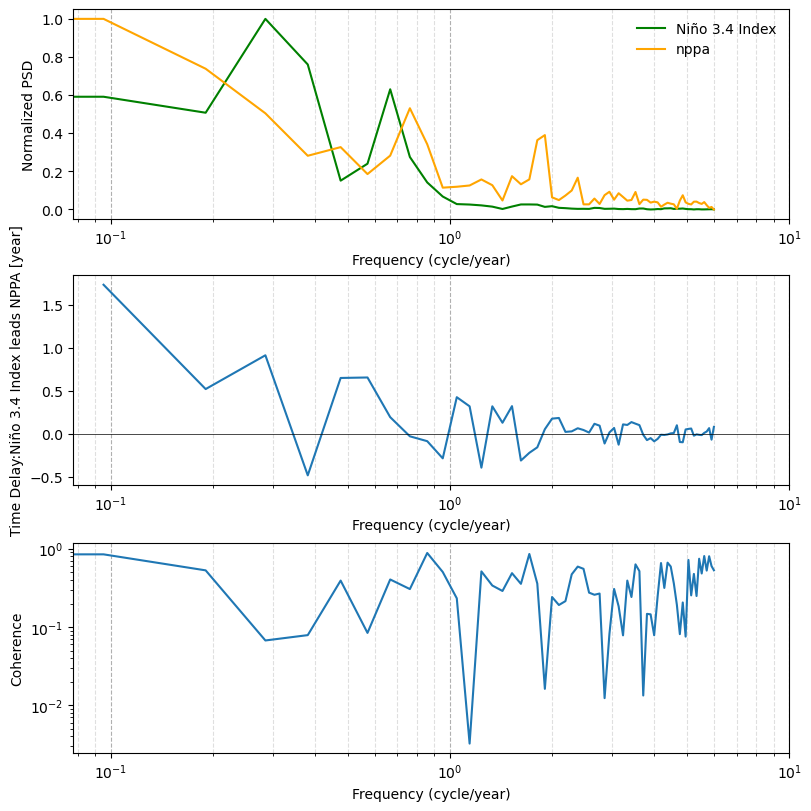

In [2]:
#same period
common_times = np.intersect1d(npp.date, nino.time)

npp = npp.sel(date=common_times)
nino = nino.sel(time=common_times)
fs = 12
N = len(npp)
chunk = 2

fx, Pxx = signal.welch(nino, window='hann', fs=fs ,nperseg=int(N/chunk),detrend=False)
fy, Pyy = signal.welch(npp, window='hann', fs=fs ,nperseg=int(N/chunk),detrend=False)
f, Pxy = signal.csd(nino, npp, fs=fs, nperseg=int(N/chunk) ,detrend=False)
# 주파수별 위상 차이 계산
phase_xy = np.angle(Pxy)
# 주파수별 시간적 지연 계산
tau = phase_xy / (2 * np.pi * f)
# Coherence 계산
f_coh, Cxy = signal.coherence(nino, npp, fs=fs, nperseg=int(N/chunk))

def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

fit_Pxx = min_max_normalize(Pxx)
fit_Pyy = min_max_normalize(Pyy)

fig, ax = plt.subplots(3,1, figsize=(8,8), constrained_layout=True)

ax[0].semilogx(fx, fit_Pxx, label=nino_txt, color= 'green')
ax[0].semilogx(fy, fit_Pyy,'-', label = 'nppa', color = 'orange')
ax[0].set_ylabel(f'Normalized PSD')
ax[0].legend(frameon = False)

ax[1].semilogx(f, tau, label='Time delay')
ax[1].axhline(0, color="black", lw = 0.5)  # add a black line at x=0
ax[1].set_ylabel(f'Time Delay:{nino_txt} leads NPPA [year]')
# ax[1].set_title(f'Time Delay: {nino_txt} leads NPPA')

ax[2].loglog(f_coh, Cxy, label='Coherence')
ax[2].set_ylabel('Coherence')

for a in ax:
    a.set_xlim((0,10))
    a.grid(True,which='major',linestyle='--', axis='x')
    a.grid(True,which='minor',linestyle='--',alpha=0.4, axis='x')
    a.set_xlabel(f'Frequency (cycle/year)')

In [3]:
def plotPSDs(ax, f, spec, rspec, spec95, spec99,funit ='cycle/year', xlabel = 'Frequency', ylabel = True ,xlim = False, ylim = False, xticks = False):
    if xlabel : ax.set_xlabel(f'{xlabel} ({funit})')
    if ylabel : ax.set_ylabel(f'PSD')

    ax.semilogx(f,spec, label='data', color= 'black')
    ax.semilogx(f,rspec,'-', label = 'red-noise fit', color = 'red')
    ax.semilogx(f,spec95,'--', label = '95% confidence', color = 'blue')
    ax.semilogx(f,spec99,'--', label = '99% confidence', color = 'orange')
    if xlim : ax.set_xlim(xlim)
    if ylim : ax.set_ylim(ylim)
    if xticks : ax.set_xticks(xticks)
    
    ax.grid(True,which='major',linestyle='--', axis='x')
    ax.grid(True,which='minor',linestyle='--',alpha=0.4, axis='x')

    ax.legend(frameon = False)
    

def calculate_autocorr(data):
    """
    Calculate and normalize the autocorrelation of a dataset.

    Parameters:
    - data (array): The input dataset for which autocorrelation is computed.

    Returns:
    - array: Normalized autocorrelation of the input data.
    """
    autocorr = np.correlate(data, data, 'full')[len(data)-1:] #return 2n-1 length so cut middle
    autocorr = autocorr/autocorr[0] #normalize

    return autocorr

def calculate_spectrums(data, fs=1, chunks=3):
    """
    Calculate the power spectrum and red noise spectrum of a dataset along with significance levels.

    Parameters:
    - data (array): The time series data.
    - fs (float): Sampling frequency of the data. Default is 1.
                  (for example, monthly data fs is 12 samples/year, in case standard unit is year)
    - chunks (int): Number of segments to divide the data for spectral analysis. Default is 3.

    Returns:
    - tuple: Tuple containing the frequency array,power spectral density,
             red noise spectrum, 95% significance level, and 99% significance level.
    """
    T = len(data) #length of thime series
    N = chunks #number of chunks

    # compute power spectrum
    f, Pxx = signal.welch(data, window='hann', fs=fs ,nperseg=int(T/N))

    #calculate alpha and red noise
    autocorr = calculate_autocorr(data)
    alpha = autocorr[1] #lag-one autocorrelation
    h = np.arange(len(f))
    rspec = (1 - alpha**2) / (1 - 2 * alpha * np.cos(np.pi * h / len(f)) + alpha**2)

    #fit red noise to psd
    ratio = np.sum(Pxx) / np.sum(rspec)
    rspec *= ratio

    # calculate significance using F-test
    dof = 2*N*1.2 #(1.2 is additional smoothing foctor for a Hanning window)
    fstat = stats.f.ppf(.99,dof,1000)
    spec99 = np.array([fstat*m for m in rspec])

    fstat = stats.f.ppf(.95,dof,1000)
    spec95 = np.array([fstat*m for m in rspec])
    

    return f, Pxx, rspec, spec95, spec99


In [4]:
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

def calculate_nor_spectrums(data, fs=1, chunks=3):
    """
    Calculate the power spectrum and red noise spectrum of a dataset along with significance levels.

    Parameters:
    - data (array): The time series data.
    - fs (float): Sampling frequency of the data. Default is 1.
                  (for example, monthly data fs is 12 samples/year, in case standard unit is year)
    - chunks (int): Number of segments to divide the data for spectral analysis. Default is 3.

    Returns:
    - tuple: Tuple containing the frequency array,power spectral density,
             red noise spectrum, 95% significance level, and 99% significance level.
    """
    T = len(data) #length of thime series
    N = chunks #number of chunks

    # compute power spectrum
    f, Pxx = signal.welch(data, window='hann', fs=fs ,nperseg=int(T/N))
    Pxx = min_max_normalize(Pxx)
    #calculate alpha and red noise
    autocorr = calculate_autocorr(data)
    alpha = autocorr[1] #lag-one autocorrelation
    h = np.arange(len(f))
    rspec = (1 - alpha**2) / (1 - 2 * alpha * np.cos(np.pi * h / len(f)) + alpha**2)

    #fit red noise to psd
    ratio = np.sum(Pxx) / np.sum(rspec)
    rspec *= ratio

    # calculate significance using F-test
    dof = 2*N*1.2 #(1.2 is additional smoothing foctor for a Hanning window)
    fstat = stats.f.ppf(.99,dof,1000)
    spec99 = np.array([fstat*m for m in rspec])

    fstat = stats.f.ppf(.95,dof,1000)
    spec95 = np.array([fstat*m for m in rspec])
    
    return f, Pxx, rspec, spec95, spec99

/var/folders/gv/5yc5yy8j1rg2ls36dbbfntr80000gn/T/ipykernel_1951/2937052878.py:9: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  if xlim : ax.set_xlim(xlim)
/var/folders/gv/5yc5yy8j1rg2ls36dbbfntr80000gn/T/ipykernel_1951/2151095630.py:27: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  a.set_xlim((0,10))


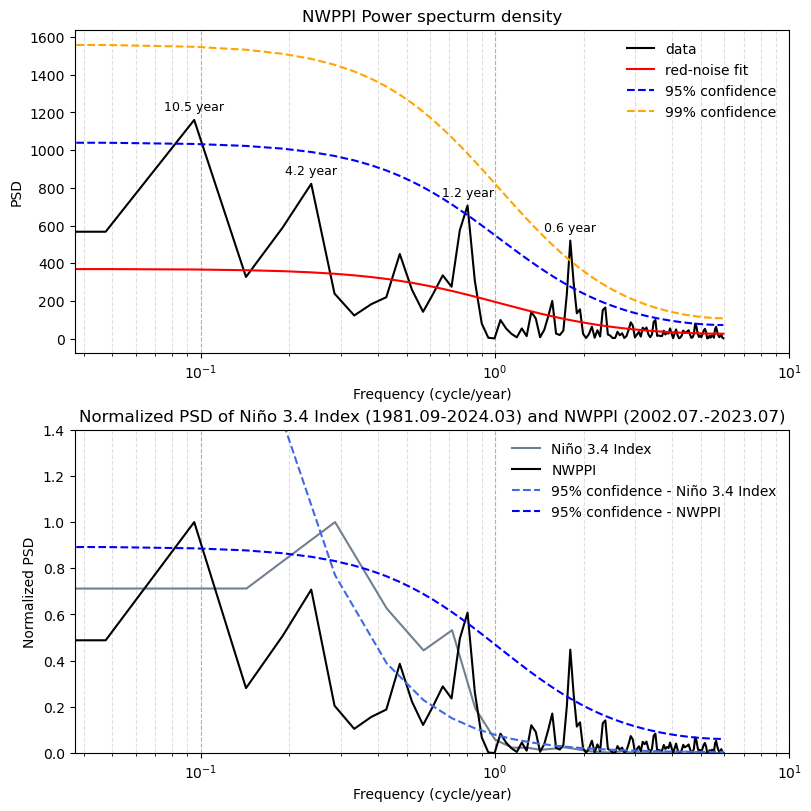

In [6]:
f1, Pxx1, rspec1, spec951, spec991 = calculate_spectrums(nino, fs = 12, chunks=3)
f2, Pxx2, rspec2, spec952, spec992 = calculate_spectrums(npp, fs = 12, chunks=1)

fig, ax = plt.subplots(2,1, figsize=(8,8), constrained_layout=True)
ax[0].set_title(f'{npp_txt} Power specturm density')
plotPSDs(ax[0], f2, Pxx2, rspec2, spec952, spec992, xlim =(0, 10))

peaks, _ = signal.find_peaks(Pxx2, height=500)

for peak in peaks:
    ax[0].text(f2[peak], Pxx2[peak]+50, f'{1/f2[peak]:.1f} year', fontsize=9, ha='center')

f1, Pxx1, rspec1, spec951, spec991 = calculate_nor_spectrums(nino, fs = 12, chunks=3)
f2, Pxx2, rspec2, spec952, spec992 = calculate_nor_spectrums(npp, fs = 12, chunks=1)

ax[1].set_title(f'Normalized PSD of {nino_txt} (1981.09-2024.03) and {npp_txt} (2002.07.-2023.07)')
nino_txt_c = 'slategrey'
ax[1].semilogx(f1, Pxx1, label=nino_txt, color= nino_txt_c)
ax[1].semilogx(f2, Pxx2,'-', label = npp_txt, color = 'black')
ax[1].set_ylabel(f'Normalized PSD')

ax[1].semilogx(f1,spec951,'--', label = f'95% confidence - {nino_txt}', color = 'royalblue')
ax[1].semilogx(f2,spec952,'--', label = f'95% confidence - {npp_txt}', color = 'b')
ax[1].set_ylim((0,1.4))

for a in ax:
    a.set_xlim((0,10))
    a.grid(True,which='major',linestyle='--', axis='x')
    a.grid(True,which='minor',linestyle='--',alpha=0.4, axis='x')
    a.set_xlabel(f'Frequency (cycle/year)')
    a.legend(frameon = False)

In [7]:
f1

array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
       0.71428571, 0.85714286, 1.        , 1.14285714, 1.28571429,
       1.42857143, 1.57142857, 1.71428571, 1.85714286, 2.        ,
       2.14285714, 2.28571429, 2.42857143, 2.57142857, 2.71428571,
       2.85714286, 3.        , 3.14285714, 3.28571429, 3.42857143,
       3.57142857, 3.71428571, 3.85714286, 4.        , 4.14285714,
       4.28571429, 4.42857143, 4.57142857, 4.71428571, 4.85714286,
       5.        , 5.14285714, 5.28571429, 5.42857143, 5.57142857,
       5.71428571, 5.85714286, 6.        ])

/var/folders/gv/5yc5yy8j1rg2ls36dbbfntr80000gn/T/ipykernel_3642/4161340947.py:36: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  a.set_xlim((0,10))


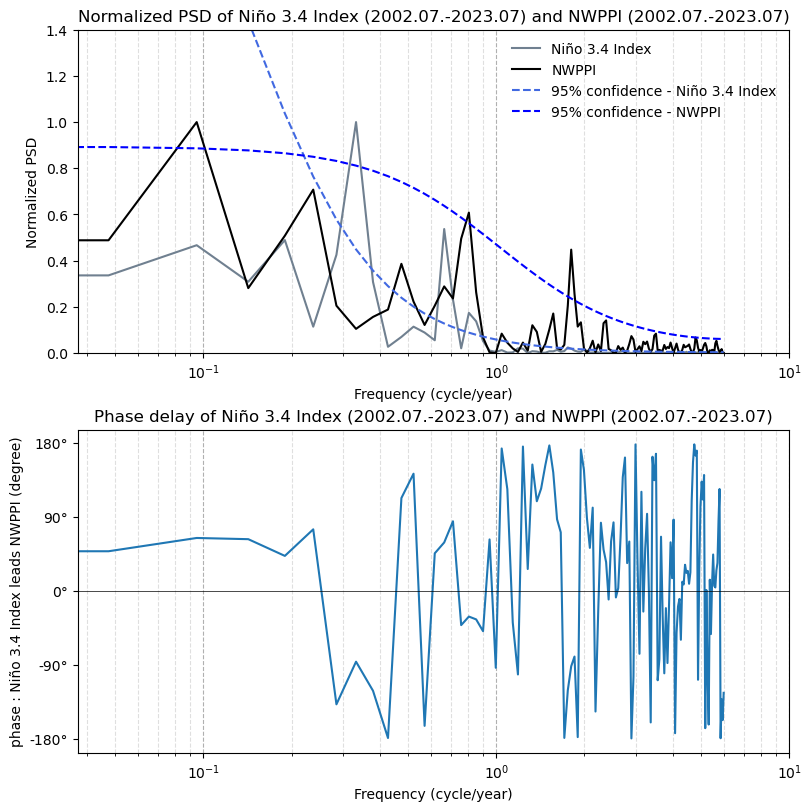

In [96]:
#same period
common_times = np.intersect1d(npp.date, nino.time)

npp = npp.sel(date=common_times)
nino = nino.sel(time=common_times)
N=len(npp)
fs = 12
chunk =1

fx, Pxx, rspecx, spec95x, spec99x = calculate_nor_spectrums(nino, fs = fs, chunks=chunk)
fy, Pyy, rspecy, spec95y, spec99xy = calculate_nor_spectrums(npp, fs = fs, chunks=chunk)

f, Pxy = signal.csd(nino, npp, fs=fs, nperseg=int(N/chunk) ,detrend=False)

# 주파수별 위상 차이 계산
phase_xy = np.angle(Pxy, deg=True)

fig, ax = plt.subplots(2,1, figsize=(8,8), constrained_layout=True)

ax[0].set_title(f'Normalized PSD of {nino_txt} (2002.07.-2023.07) and {npp_txt} (2002.07.-2023.07)')
ax[0].semilogx(fx, Pxx, label=nino_txt, color= nino_txt_c)
ax[0].semilogx(fy, Pyy,'-', label = npp_txt, color = 'black')
ax[0].semilogx(fx,spec95x,'--', label = f'95% confidence - {nino_txt}', color = 'royalblue')
ax[0].semilogx(fy,spec95y,'--', label = f'95% confidence - {npp_txt}', color = 'b')
ax[0].set_ylabel(f'Normalized PSD')
ax[0].set_ylim((0,1.4))
ax[0].legend(frameon = False)

ax[1].set_title(f'Phase delay of {nino_txt} (2002.07.-2023.07) and {npp_txt} (2002.07.-2023.07)')
ax[1].semilogx(f, phase_xy, label='phase')
ax[1].axhline(0, color="black", lw = 0.5)  # add a black line at x=0
ax[1].set_yticks([-180, -90, 0, 90, 180], ['-180°', '-90°', '0°', '90°', '180°'])
ax[1].set_ylabel(f'phase : {nino_txt} leads {npp_txt} (degree)')

for a in ax:
    a.set_xlim((0,10))
    a.grid(True,which='major',linestyle='--', axis='x')
    a.grid(True,which='minor',linestyle='--',alpha=0.4, axis='x')
    a.set_xlabel(f'Frequency (cycle/year)')

In [118]:
1/0.4

2.5

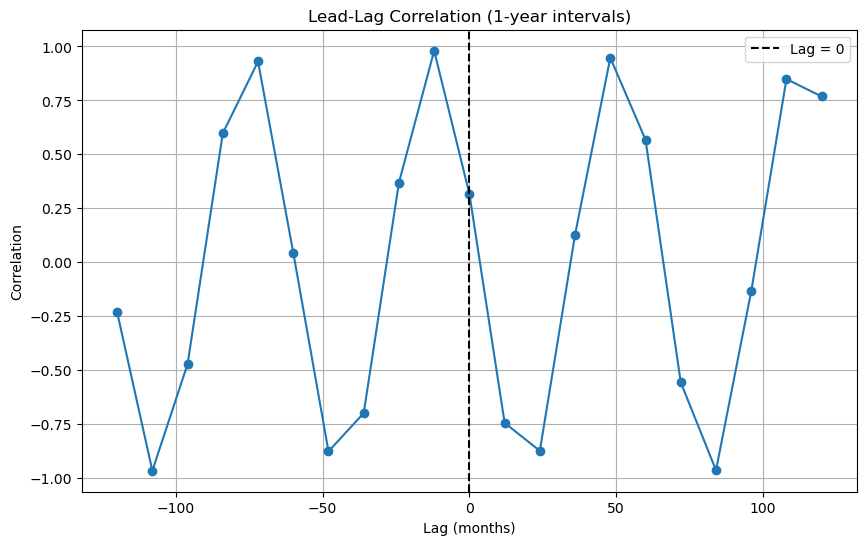

In [99]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# 예제 데이터 생성 (20년 길이의 월별 데이터)
np.random.seed(0)
n_years = 20
n_months = n_years * 12
t = np.arange(n_months)
data1 = np.sin(0.1 * t) + np.random.normal(0, 0.1, n_months)
data2 = np.sin(0.1 * (t - 12)) + np.random.normal(0, 0.1, n_months)  # data1에 대해 12개월(1년) 지연

# xarray DataArray 생성
da1 = xr.DataArray(data1, dims='time', coords={'time': t})
da2 = xr.DataArray(data2, dims='time', coords={'time': t})

# lead-lag correlation 계산 함수
def lead_lag_correlation(da1, da2, max_years):
    correlations = []
    lags = range(-max_years * 12, (max_years + 1) * 12, 12)
    data1 = da1.values
    data2 = da2.values
    for lag in lags:
        if lag < 0:
            corr = np.corrcoef(data1[:lag], data2[-lag:])[0, 1]
        elif lag > 0:
            corr = np.corrcoef(data1[lag:], data2[:-lag])[0, 1]
        else:
            corr = np.corrcoef(data1, data2)[0, 1]
        correlations.append(corr)
    return lags, correlations

# 최대 지연 연도 설정
max_years = 10

# lead-lag correlation 계산
lags, correlations = lead_lag_correlation(da1, da2, max_years)

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(lags, correlations, marker='o')
plt.axvline(0, color='k', linestyle='--', label='Lag = 0')
plt.xlabel('Lag (months)')
plt.ylabel('Correlation')
plt.title('Lead-Lag Correlation (1-year intervals)')
plt.legend()
plt.grid(True)
plt.show()


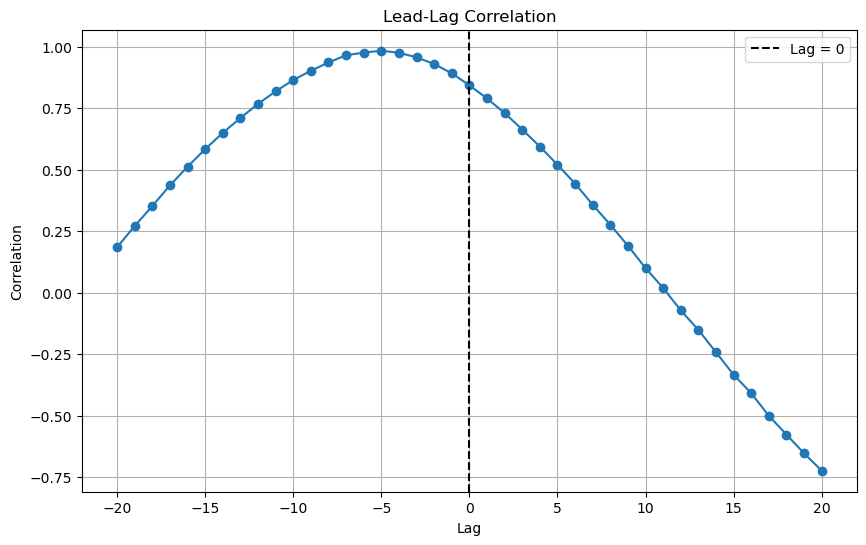

In [120]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# 예제 데이터 생성
np.random.seed(0)
n = 100
t = np.arange(n)
data1 = np.sin(0.1 * t) + np.random.normal(0, 0.1, n)
data2 = np.sin(0.1 * (t - 5)) + np.random.normal(0, 0.1, n)  # data1에 대해 5 타임 스텝 지연

# xarray DataArray 생성
da1 = xr.DataArray(data1, dims='time', coords={'time': t})
da2 = xr.DataArray(data2, dims='time', coords={'time': t})

# lead-lag correlation 계산 함수
def lead_lag_correlation(da1, da2, max_lag):
    correlations = []
    lags = np.arange(-max_lag, max_lag + 1)
    data1 = da1.values
    data2 = da2.values
    for lag in lags:
        if lag < 0:
            corr = np.corrcoef(data1[:lag], data2[-lag:])[0, 1]
        elif lag > 0:
            corr = np.corrcoef(data1[lag:], data2[:-lag])[0, 1]
        else:
            corr = np.corrcoef(data1, data2)[0, 1]
        correlations.append(corr)
    return lags, correlations

# 최대 지연 시간 설정
max_lag = 20

# lead-lag correlation 계산
lags, correlations = lead_lag_correlation(da1, da2, max_lag)

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(lags, correlations, marker='o')
plt.axvline(0, color='k', linestyle='--', label='Lag = 0')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Lead-Lag Correlation')
plt.legend()
plt.grid(True)
plt.show()


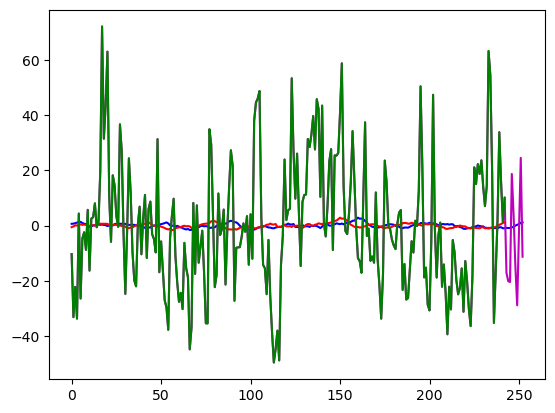

In [124]:
data1 = nino.values
data2 = npp.values

plt.plot(data1, color='b')
plt.plot(data2, color='m')

lag = 10
plt.plot(data1[lag:],color='r')
plt.plot(data2[:-lag], color='green')

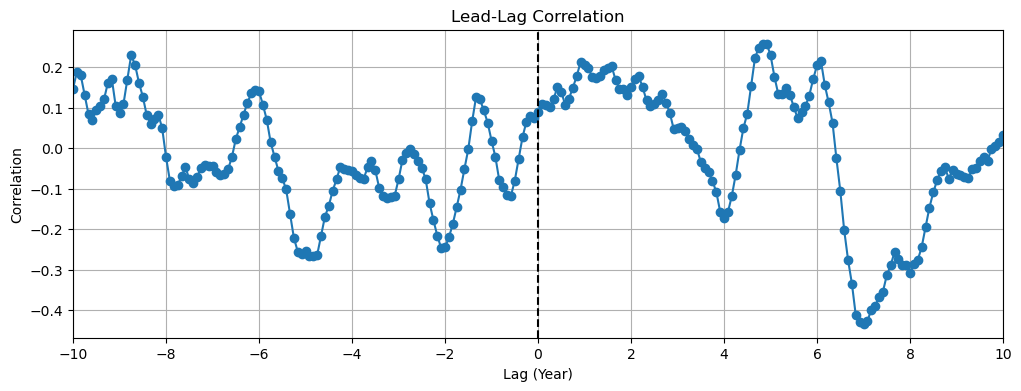

In [121]:
# 최대 지연 시간 설정
max_lag = 10*12

# lead-lag correlation 계산
lags, correlations = lead_lag_correlation(nino, npp, max_lag)

# 그래프 시각화
plt.figure(figsize=(12, 4))
plt.plot(lags/12, correlations, marker='o')
plt.axvline(0, color='k', linestyle='--', label='Lag = 0')
plt.xlabel('Lag (Year)')
plt.ylabel('Correlation')
plt.title('Lead-Lag Correlation')
plt.xticks([-10, -8, -6,-4,-2, 0, 2,4,6,8,10])
plt.xlim((-10,10))
plt.grid(True)
plt.show()

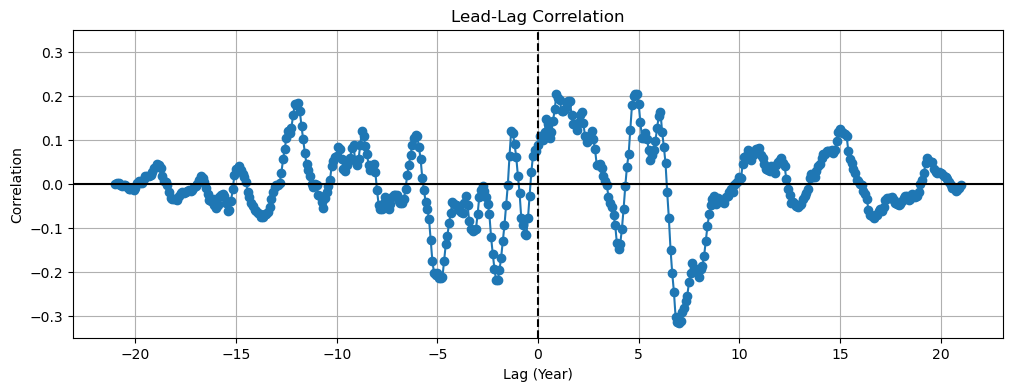

In [25]:
def ccf(data1,data2):
    p = data1
    q = data2
    p = (p - np.mean(p)) / (np.std(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')/len(p)
    return c
correlations = ccf(nino,npp)
lags = signal.correlation_lags(len(nino),len(npp))

plt.figure(figsize=(12, 4))
plt.plot(lags/12, correlations, marker='o')
plt.axvline(0, color='k', linestyle='--', label='Lag = 0')
plt.axhline(0, color='k', linestyle='-', label='Corr = 0')
plt.xlabel('Lag (Year)')
plt.ylabel('Correlation')
plt.title('Lead-Lag Correlation')
plt.xticks([-20, -15,-10,-5, 0,5,10,15,20])
# plt.xlim((-10,10))
plt.ylim((-0.35,0.35))
plt.grid(True)
plt.show()

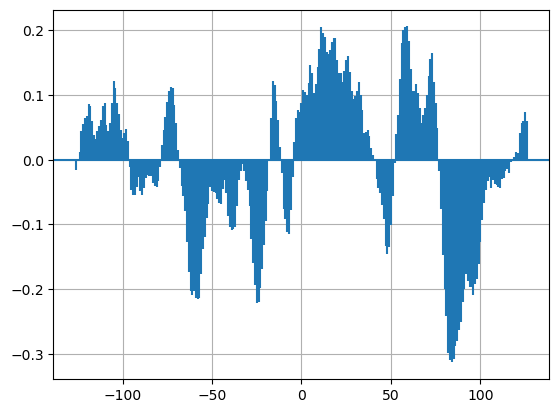

In [11]:
plt.xcorr(nino,npp,maxlags=len(nino)//2)
plt.grid(True)
plt.show()

In [12]:
len(nino)//2

126

In [11]:
n= xr.open_dataarray('../../Data/1degree/t_fldmean_vg.nc').squeeze()
n

<xarray.DataArray 'vgpm' (date: 253)> Size: 2kB
[253 values with dtype=float64]
Coordinates:
  * date     (date) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2023-07-01
    lon      float64 8B 0.0
    lat      float64 8B 0.0
Attributes: (12/20)
    Central_Azimuth:      0
    Hole Value:           -9999
    Intercept:            0
    Isotropic:            0
    Latitude Center:      0
    Limit:                -90, -180, 90, 180
    ...                   ...
    Source:               not specified
    Start Time:           1094022000
    Start Time String:    09/01/2004 00:00:00
    Stop Time:            1096613999
    Stop Time String:     09/30/2004 23:59:59
    Units:                mgC m-2 day-1

In [12]:
n.mean()

<xarray.DataArray 'vgpm' ()> Size: 8B
array(182.19606576)
Coordinates:
    lon      float64 8B 0.0
    lat      float64 8B 0.0